# Active-learning tutorial: Preparing and evaluating committee MACE models for protonated water clusters

In this tutorial, we will be preparing and working a committee of MACE models (C-MACE?) to describe two different protonated water clusters in the gas phase 
and illustrate important aspects of committee-based active learning.

In the first part, we will leverage the accessible uncertainty measure to screen a wide pool of candidate geometries originating from a DFT simulation of the Zundel cation (H$_5$O$_2^+$) to create a robust and concise training data set.

In the second part, we will use the obtained model to perform an exploratory simulation of the related Eigen cation (H$_9$O$_3^+$) and, once again, rely on active learning to select the most relevant training structures
in order for the model to gain accuracy on a new, unexplored part of the configuration space.

## To Do 

- estimate how expensive things are - ideally we would be able to run trainings and simulations on the spot (more instructive)
- if we want to go from the cations to the liquid water/ice active learning, we can do no training or simulations on the spot and will have to prepare and provide everything ready-made
- fix E0 alignment to minimize committee disagreement
- default to multiprocesssing parallel training everywhere

## Import modules

This is all the modules and functions that we will need to run this tutorial.

In [10]:
import os, glob, re
import multiprocessing
from tqdm.notebook import tqdm
from IPython.display import Image, display

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ase.io import read, write # read and write structures

# import functions to run this tutorial
from myfunctions import train_mace     # train MACE model
from myfunctions import eval_mace      # evaluate MACE model
from myfunctions import extxyz2energy  # extract energy from extxyz file
from myfunctions import extxyz2array  # extract forces from extxyz file
from myfunctions import run_qbc        # run Query by Committee

In [11]:
plt.style.use('notebook.mplstyle')

# Part I

In the first part, we will tackle the Zundel cation (shown below) using a committee of MACE models.
To actively select structures for the training set, we need to perform **query by committee** (QbC) on a provided candidate set.

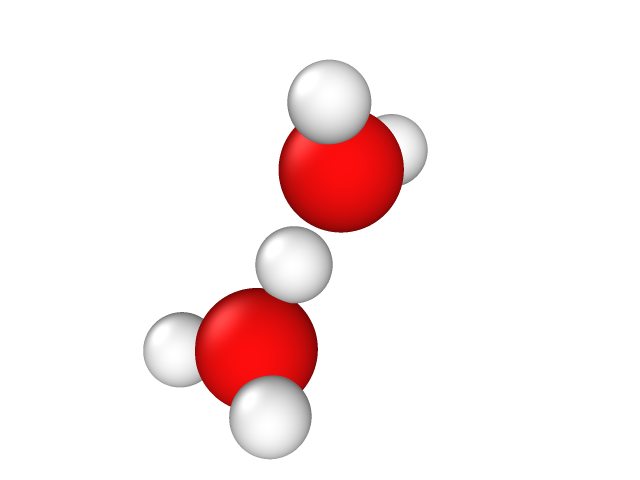

In [12]:
display(Image(filename='../initial-datasets/zundel/zundel.png'))

In [13]:
n_init_train = 20
n_test = 50  
n_committee = 4
parallel = True
md_folder = "md"
init_train_folder = "init-train"
qbc_folder = "qbc-work" # if you modify this, add the new folder to .gitignore
n_iter_qbc = 10
n_add_iter = 20    
np.random.seed(0) 
seeds = np.random.randint(0, 2**32 - 1, size=n_committee, dtype=np.uint32)

In [19]:
#np.random.seed(0)
os.makedirs(f'{init_train_folder}', exist_ok=True)
os.makedirs(f'{init_train_folder}/config', exist_ok=True)
os.makedirs(f'{init_train_folder}/models', exist_ok=True)
os.makedirs(f'{init_train_folder}/eval', exist_ok=True)
os.makedirs(f'{init_train_folder}/structures', exist_ok=True)
os.makedirs(f'{md_folder}', exist_ok=True)

## Select initial training structures

The first step in QbC is to select a small number of random structures (here `n_init_train`) to train a very preliminary committee that can, however, already provide a measure of uncertainty.

We start by selecting these initial structures and, at the same time, separating out a small portion of our data points for testing purposes.

In [20]:
# Read the all the structures from file
structures = read('../initial-datasets/zundel/train.extxyz', index=':')
print(f'Total number of structures: {len(structures)}')
# view(structures)  # Opens an interactive GUI window to visualize the structures

Total number of structures: 1000


In [21]:
# Create the initial training and test sets
selected_indices = np.random.choice(len(structures), size=(n_init_train + n_test), replace=False)
remaining_candidate_idcs = np.delete(np.arange(len(structures)), selected_indices)

indices_train = selected_indices[:n_init_train]
indices_test = selected_indices[n_init_train:]
assert len(indices_train) == n_init_train
assert len(indices_test) == n_test

print(f'\nSelected indices for training:\n\t{indices_train}')
print(f'\nSelected indices for test:\n\t{indices_test}')

initial_training_set = [structures[i] for i in indices_train]
test_set = [structures[i] for i in indices_test]
remaining_structures = [structures[i] for i in remaining_candidate_idcs]

print(f"\nSaving the initial training set to '{init_train_folder}structures/init.train.extxyz'")
write(f'{init_train_folder}/structures/init.train.extxyz', initial_training_set, format='extxyz')

print(f"\nSaving the test set to '{init_train_folder}/structures/test.extxyz'")
write(f'{init_train_folder}/structures/test.extxyz', test_set, format='extxyz')

print(f"\nSaving the remaining structures to '{init_train_folder}/structures/remaining.extxyz'")
write(f'{init_train_folder}/structures/remaining.extxyz', remaining_structures, format='extxyz')


Selected indices for training:
	[ 18 939 532 671 506 276 601 845 386 201  84 641 417 586 356 928 166 736
 303 237]

Selected indices for test:
	[711 852 664 628 148 123 342 429 246 795 233 107  27 850  76  17 687 163
  90 390 558 325 787 556 515 798 353 531 463 335 489 145 706 759 137 127
 525 791 774 307 290 424 673  67 772 263 855 810 880 514]

Saving the initial training set to 'init-trainstructures/init.train.extxyz'

Saving the test set to 'init-train/structures/test.extxyz'

Saving the remaining structures to 'init-train/structures/remaining.extxyz'


## Initial Training

Now we get to the initial training of the committee.

Notice that we provide `structures/init.train.set.extxyz` as the training data set.

In [22]:
# Define different values for each config
for i in range(n_committee):
    filename = f"{init_train_folder}/config/config.{i}.yml"
    name = f"mace.com={i}"
    
    config_text = f"""
# You can modify the following parameters
num_channels: 16
max_L: 0            # take it larger but not smaller
max_ell: 1          # take it larger but not smaller
correlation: 1      # take it larger but not smaller
num_interactions: 2 # take it larger but not smaller

# num_radial_basis: 5
# num_cutoff_basis: 3

# ... but you can also modify these ones
r_max: 4.0
batch_size: 4
# valid_batch_size: 4
# valid_fraction: 0.2
max_num_epochs: 10000 # this is basically early stopping
patience: 20

# But please, do not modify these parameters!
model: "MACE"
name: "{name}"

model_dir      : "{init_train_folder}/models"
log_dir        : "{init_train_folder}/log"
checkpoints_dir: "{init_train_folder}/checkpoints"
results_dir    : "{init_train_folder}/results"
train_file     : "{init_train_folder}/structures/init.train.extxyz"

# why this does not work?
# test_file      : "{init_train_folder}/structures/test.extxyz"

energy_key: "REF_energy"
forces_key: "REF_forces"
energy_weight: 1
forces_weight: 10
E0s: 
  1: -13.7487804074635
  8: -2045.41865185226
device: cpu
swa: false
seed: {seeds[i]}
restart_latest: False
"""

    with open(filename, "w") as f:
        f.write(config_text)

    print(f"Wrote {filename}")

Wrote init-train/config/config.0.yml
Wrote init-train/config/config.1.yml
Wrote init-train/config/config.2.yml
Wrote init-train/config/config.3.yml


In [23]:
# train a committee of MACE models
def train_single_model(n):
    train_mace(f"{init_train_folder}/config/config.{n}.yml")
    
if parallel: # parallel version: it should take around 25s 
    print(f"Training {n_committee} models in parallel")
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        pool.map(train_single_model, range(n_committee))
        
else: # serial version: it should take around 1m
    print(f"Training {n_committee} models in serial\n")
    for n in range(n_committee):
        print(f"Training model {n}")
        train_single_model(n)
        
for n in range(n_committee):
    os.remove(f"{init_train_folder}/models/mace.com={n}.model")
        
# clean_output(init_train_folder,n_committee)

Training 4 models in parallel


## Evaluation of the committee disagreement 

Now that we have our preliminary model, we will ask it to predict the energies on all remaining structures in the candidate pool that have not been selected into the training set yet.

That will allow us to evaluate several very important quantities.

The first is the **average committee energy prediction** 

$$
\overline{E}(\mathbf{q}_i) 
= \frac{1}{N_\mathrm{c}} \sum_{n}^{N_\mathrm{c}} E_n(\mathbf{q}_i),
$$

which is an important quantity in committee based models because it is typically a more accurate prediction and represents the potential energy surface on which MD is performed.

To that end, we also have the **average committee force prediction** on the $\alpha$-th atom

$$
\overline{\mathbf{F}}_{\alpha}(\mathbf{q}_i) 
= \frac{1}{N_\mathrm{c}} \sum_{n}^{N_\mathrm{c}} \mathbf{F}_{\alpha, n}(\mathbf{q}_i).
$$

The second one is the **committee disagreement on energy** which we define as the standard deviation of the energy predicitons

$$
\sigma_E(\mathbf{q}_i)
= \sqrt{\frac{1}{N_\mathrm{c}} \sum_{n}^{N_\mathrm{c}} \left[ E_n(\mathbf{q}_i) - \overline{E}(\mathbf{q}_i) \right]^2}.
$$

Consistently, we have a **committee disagreement on per-atom forces**

$$
\sigma_{F_\alpha}(\mathbf{q}_i)
= \sqrt{\frac{1}{N_\mathrm{c}} \sum_{n}^{N_\mathrm{c}} \left[ \mathbf{F}_{\alpha, n}(\mathbf{q}_i) - \overline{\mathbf{F}}_\alpha(\mathbf{q}_i) \right]^2}.
$$

and an averaged **committee disagreement on forces**

$$
\sigma_F(\mathbf{q}_i)
= \frac{1}{N_\mathrm{atoms}} \sum_{n}^{N_\mathrm{atoms}} \sigma_{F_\alpha}(\mathbf{q}_i).
$$

This quantity is the centerpiece of QbC and is preferred over $\sigma_E$ for several practical reasons.

It serves as an uncertainty measure: the more the committee members disagree, the less sure they are about what the correct output should actually be.

As such, the committee disagreement *correlates* with the actual error of prediction (*i.e.*, the generalization error) but it is important to remember that they are not the same quantity! We will come back to this shortly.

In [ ]:
# Evaluate the MACE models
for n in tqdm(range(n_committee)):
    eval_mace(f'{init_train_folder}/models/mace.com={n:d}_compiled.model',
              'init-train/structures/init.train.extxyz',
              f'{init_train_folder}/eval/train_{n:02d}.extxyz')
    

In [ ]:
# read in predicted energies, evaluate average energies and disagreements
energies       = np.array([extxyz2energy(f'{init_train_folder}/eval/train_{n:02d}.extxyz', keyword='MACE_energy') for n in tqdm(range(n_committee))])
forces         = np.array([extxyz2array(f'{init_train_folder}/eval/train_{n:02d}.extxyz', keyword='MACE_forces') for n in tqdm(range(n_committee))])

avg_energy     = energies.mean(axis=0) # (1000,)
disagreement_e = energies.std(axis=0)  # (1000,)

avg_forces     = forces.mean(axis=0)   # (1000, 7, 3)
disagreement_f = forces.std(axis=0)    # (1000, 7, 3)

tot_dis_f      = np.mean(np.linalg.norm(disagreement_f,axis=2),axis=1)

In [ ]:
for n, e in enumerate(energies):
    plt.plot(e, label=rf'$E_{n:d}$', alpha=0.5,linewidth=0.5)
plt.plot(avg_energy, label=r'$\overline{E}$', color='k',linewidth=1)
plt.legend(loc="upper right",bbox_to_anchor=(1.15, 1), borderaxespad=0.)
plt.xlabel('Data point index')
plt.ylabel('Energy [eV]')
plt.title('Energy prediction of the initial committee model')
plt.show()

In [ ]:
for n, f in enumerate(forces):
    plt.plot(f[:, -1, -1], label=rf'$F_{n:d}$', alpha=0.5,linewidth=0.5)
plt.plot(avg_forces[:, -1, -1], label=r'$\overline{F}$', color='k',linewidth=0.5)
plt.legend(loc="upper right",bbox_to_anchor=(1.15, 1), borderaxespad=0.)
plt.xlabel('Data point index')
plt.ylabel(r'Force component [eV/$\mathrm{\AA}$]')
plt.title('Force prediction $F_z$ of the H$^+$ by the initial committee model')
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 3), sharex=True)

# Top plot: forces
ax1.plot(tot_dis_f, color="red", linewidth=0.5,label="forces")
ax1.set_ylabel(r'$\sigma_F$ [eV/$\mathrm{\AA}$]')
ax1.grid(True)
ax1.legend()

# Bottom plot: energy
ax2.plot(disagreement_e, color="blue", linewidth=0.5,label="energy")
ax2.set_xlabel('Data point index')
ax2.set_ylabel(r'$\sigma_E$ [eV]')
ax2.grid(True)
ax2.legend()

plt.suptitle('Committee disagreement')
plt.tight_layout()
plt.show()


# Select relevant training data via Query by Committee (QbC)

At this point, we have an initial committee model that can predict $\sigma_E$ for arbitrary data points from the remaining candidate pool.

With this ability in our hands, we can now proceed to the actual execution of the QbC procedure.

There one iteratively predicts $\sigma_E$ over the remaining candidate pool, selects a fixed number of candidate geometries that feature the **highest** $\sigma_E$ and adds them to the training set and retrains the committee.

Have a look at the function `run_qbc()` contained in the `myfunctions.py` file (it is stashed away because it is a bit wordy, but it exactly captures the idea of the previous sentence). 

In [ ]:
# Run QbC
os.makedirs(qbc_folder, exist_ok=True)
os.makedirs(f'{qbc_folder}/config', exist_ok=True)
# seeds = np.random.randint(0, 2**32 - 1, size=n_committee, dtype=np.uint32)
for i in range(n_committee):
    filename = f"{qbc_folder}/config/config.{i}.yml"
    name = f"mace.com={i}"
    
    config_text = f"""
# You can modify the following parameters
num_channels: 16
max_L: 0            # take it larger but not smaller
max_ell: 1          # take it larger but not smaller
correlation: 1      # take it larger but not smaller
num_interactions: 2 # take it larger but not smaller

# ... but you can also modify these ones
r_max: 4.0
batch_size: 4
max_num_epochs: 10000 # this is basically early stopping
patience: 10       # we are a bit in a rush

# But please, do not modify these parameters!
model: "MACE"
name: "{name}"

model_dir      : "{qbc_folder}/models"
log_dir        : "{qbc_folder}/log"
checkpoints_dir: "{qbc_folder}/checkpoints"
results_dir    : "{qbc_folder}/results"

train_file: "{qbc_folder}/train-iter.extxyz"
# test_file : "{init_train_folder}/structures/test.extxyz"
energy_key: "REF_energy"
forces_key: "REF_forces"
energy_weight: 1
forces_weight: 100



E0s: 
  1: -13.7487804074635
  8: -2045.41865185226
device: cpu
swa: false
seed: {seeds[i]}
restart_latest: True
distributed: False

"""

    with open(filename, "w") as f:
        f.write(config_text)

    print(f"Wrote {filename}")

In [ ]:
# Attention: this function will not
run_qbc(
    init_train_folder=init_train_folder,
    init_train_file=f"{init_train_folder}/structures/init.train.extxyz", # initial training dataset
    fn_candidates=f'{init_train_folder}/structures/remaining.extxyz',    # candidate structures
    test_dataset=f'{init_train_folder}/structures/test.extxyz',          # test set
    n_iter=n_iter_qbc,                                                   # number of QbC iterations
    config=f'{qbc_folder}/config',                                       # folder with config files
    ofolder=qbc_folder,                                                  # folder to save the QBC results
    n_add_iter=n_add_iter,                                               # number of structures to add in each iteration
    recalculate_selected=False,                                          # whether to recalculate the selected structures with DFT (part 2)
    parallel=parallel
);
# it should take 9m

### Monitoring QbC convergence

How does one know when the QbC cycle has converged? Simply setting a threshold value for $\sigma_E$ is not the best idea since one does not *a priori* know what it should be.

A better way to look at it is to consider the QbC converged once all the *unlearned* information has been extracted from the candidate set and the committee is no longer learning anything new.

To visualize this, we can plot the evolution of $\sigma_E$ for each new added batch of structures and see how that comes closer to the value of $\sigma_E$ averaged over the candidate pool.

In practice one stops the QbC once those curves reach a plateau.

In [ ]:
n_training_structures   = np.arange(n_init_train,n_iter_qbc*n_add_iter+n_init_train,n_add_iter)
sigma = np.loadtxt('qbc-work/disagreement.txt').T

# --- First plot: Selected ---
plt.plot(n_training_structures, sigma[0], '-o', label='Selected', color="blue")
plt.fill_between(n_training_structures,sigma[0]-sigma[2],sigma[0]+sigma[2],color="blue",alpha=0.2,linewidth=0)

# --- Second plot: Candidates ---
plt.plot(n_training_structures, sigma[1], '-o', label='Candidates', color="red")
plt.fill_between(n_training_structures,sigma[1]-sigma[3],sigma[1]+sigma[3],color="red",alpha=0.2,linewidth=0)

plt.legend()
plt.xlabel('n. training structures')
plt.ylabel(r'$\sigma_F$ [eV/$\mathrm{\AA}$]')
plt.show()

### Test dataset

In [ ]:
energy = None
all_energy = None
for i_iter in range(n_iter_qbc):
    predictions = [None]*n_committee
    for n_model in range(n_committee):
        file = f"{qbc_folder}/eval/test.model={n_model}.iter={i_iter}.extxyz"
        structures = read(file,index=":")
        if energy is None:
            energy = np.zeros((len(structures),n_committee))
            all_energy = np.zeros((n_iter_qbc,len(structures),n_committee))
        energy[:,n_model] = [ atoms.info["MACE_energy"] for atoms in structures ]
    all_energy[i_iter,:,:] = energy
np.save(f"{qbc_folder}/test-energy.npy",all_energy)

In [ ]:
disagreement = np.std(all_energy,axis=2)
disagreement_mean = np.mean(disagreement,axis=1)
disagreement_std  = np.std(disagreement,axis=1)

In [ ]:
n_training_structures   = np.arange(n_init_train,n_iter_qbc*n_add_iter+n_init_train,n_add_iter)
plt.plot(n_training_structures, disagreement_mean, '-o', label='Test', color="green")
plt.legend()
plt.xlabel('n. training structures')
plt.ylabel(r'$\sigma(E)$ [eV]')
plt.show()

## Run FHI-aims

In [ ]:
# %%capture
# from myfunctions import run_aims
# run_aims(
#     structures=to_run,
#     folder='aims',
#     command=f"mpirun -n 4 /home/stoccoel/codes/FHIaims-polarization/build/polarization-debug/aims.250131.scalapack.mpi.x",
#     control="../aims/control.in"
# )